Install PyTorch

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision

Import the required packages

What is PyTorch?
It’s a Python based scientific computing package targeted at two sets of audiences:

A replacement for NumPy to use the power of GPUs
a deep learning research platform that provides maximum flexibility and speed

In [0]:
import torch 
import torchvision
import numpy as np
import matplotlib.pyplot as plt 

from IPython import display 
import time

%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'
np.random.seed(seed=485)

Initil values

In [0]:
n = 28*28   # number of image pixels
m = 60000   # number of images in training set
k = 10      # number of classes
eta = 0.1  # learning rate parameter
epsinit = 0.01  # initial size of synaptic weights
w = epsinit*torch.rand(k,n)   # random initialization of weight vector
b = epsinit*torch.rand(1)    # random initialization of bias 

tmax = 60000           # number of learning updates
errcl = torch.zeros(tmax)    # classification error vs. time
loss = torch.zeros(tmax)


Create a custom plot fn for matrix data. pyplot's built in "matshow" will not let us tile multiple images.

In [0]:
def plot_image(image):
    nr, nc = image.size() 
    extent = [-0.5, nc-0.5, nr-0.5, -0.5]
    plt.imshow(image.numpy(), extent=extent, origin='upper', interpolation='nearest') 

Define a function to generate one_hot matrix from data set: 

In [0]:
def one_hot(sample_count, class_count, labels):
    one_hot_matrix = torch.zeros(sample_count,class_count)
    index = np.arange(sample_count)
    one_hot_matrix[index,labels] = 1
    return one_hot_matrix

Set up train and test data and the one_hot matrix:

In [0]:
mnist_train = torchvision.datasets.MNIST(root='data', train=True, download=True) # train data only
mnist_test = torchvision.datasets.MNIST(root='data', train=False, download=True) # test data only

trainindices = torch.randperm(60000)
trainimages = mnist_train.train_data[trainindices]
trainlabels = mnist_train.train_labels[trainindices]

testindices = torch.randperm(10000)
testimages = mnist_test.test_data[testindices]
testlabels = mnist_test.test_labels[testindices]

one_hot_matrix_train = torch.zeros(m,k)
one_hot_matrix_train[np.arange(m),trainlabels] = 1

Check the data shape

In [77]:
print("Data shape: {}".format(mnist_train.train_data.size()))
print("Labels shape: {}".format(mnist_train.train_labels.size()))

Data shape: torch.Size([60000, 28, 28])
Labels shape: torch.Size([60000])


**Check the one_hot matrix for the training set:**

In [82]:
print("The labels of first five samples:{}".format(trainlabels[0:5]))
print("One_hot matrix of first five samples:")
one_hot_matrix_train[0:5]

The labels of first five samples:
 2
 0
 7
 8
 5
[torch.LongTensor of size 5]

One_hot matrix of first five samples:



    0     0     1     0     0     0     0     0     0     0
    1     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     1     0     0
    0     0     0     0     0     0     0     0     1     0
    0     0     0     0     0     1     0     0     0     0
[torch.FloatTensor of size 5x10]

Functions to visualize training (displays the weight vector, input vector, and running error).

In [0]:
def plot_image(image):
    nr, nc = image.shape 
    extent = [-0.5, nc-0.5, nr-0.5, -0.5] 
    plt.imshow(image.numpy(), extent=extent, origin='upper', interpolation='nearest')
    plt.gca().grid(False)

    
def visualize(t, errcl, loss, w, x):
    errorrate = np.divide(         #length of t
        np.cumsum(errcl[: t + 1]), #normalized by the number of samples calculated. 
        range(1, t + 2) 
    )
    lossrate = np.divide(
        np.cumsum(loss[: t + 1]),
        range(1, t + 2)
    )

    display.clear_output(wait=True)

    plt.subplot(1, 4, 1)
    plot_image(np.reshape(w, [28, 28]))
    plt.title("weight vector at t = " + str(t + 1))

    plt.subplot(1, 4, 2)
    plot_image(np.reshape(x, [28, 28]))
    plt.title("input vector")

    plt.subplot(1, 4, 3)
    plt.plot(errorrate, color='red')
    plt.title("average class error = " + str(errorrate[t]))
    plt.ylim(0, 1)

    plt.subplot(1, 4, 4)
    plt.plot(lossrate, color='blue')
    plt.title("average loss = " + str(lossrate[t]))
    plt.ylim(0, 1)
    
    plt.subplots_adjust(wspace=.5)

    plt.gcf().set_size_inches(18.5, 10.5)
    display.display(plt.gcf())

In [44]:
x = trainimages[2].view(-1)                # flatten image
x = x.float()/255.0
U = torch.sum(w*x,1)    # matrix operation, U is k x 1 dimension for the single x input 
U = U - torch.max(U)
f = torch.exp(U)/torch.sum(torch.exp(U))
f



 0.0940
 0.0966
 0.1024
 0.1060
 0.0975
 0.0973
 0.1053
 0.0967
 0.1023
 0.1019
[torch.FloatTensor of size 10]

In [90]:
b = torch.randn(2)
b[0] = -1
b[1] = 1 
b


-1
 1
[torch.FloatTensor of size 2]

In [92]:
torch.sum(a * b, 1)


 0.2105
 0.0137
[torch.FloatTensor of size 2]

**Training Loops:**

In [85]:
for t in range(0, tmax):     # iterate over the train steps
    i = torch.floor(m*torch.rand(1)).long()    # choose a random example
    x = trainimages[i].view(-1)                # flatten image
    x = x.float() / 255.0                      # normalize max value to one
    
    true_label = one_hot_matrix_train[i]  # true one_hot label vector of this random sample i 
    
    U = torch.sum(w*x,1)  # matrix operation, U is tensor of size k for single x 
    U = U - torch.max(U)
    f = torch.exp(U)/torch.sum(torch.exp(U)) # same dimension as true_label above
    
    loss[t] = -torch.sum(true_label*torch.log(f))
    
    delta = true_label - f

    
    w += eta * delta * x                       # weight update
    b += eta * delta                           # bias update
    if t % 1000 == 0:    # display every 1000 time steps
        visualize(t, errcl.numpy(), loss, w, x)        
        time.sleep(0.01)    

# show final statistics
visualize(t, errcl.numpy(),loss.numpy(), w, x)  
display.clear_output(wait=True)

NameError: ignored

Plot the first image

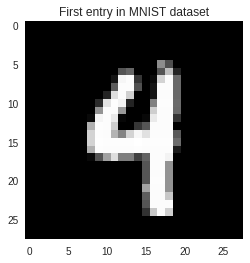

In [8]:
plt.figure()
ax = plt.subplot(111)
ax.grid(False)
plot_image(trainimages[0])
plt.title("First entry in MNIST dataset")
plt.show()

Define a function for displaying a stack of images.
imgstack is a list of mxn images 

In [0]:
def montage(imgstack):
    plt.figure()
    width = int(np.ceil(np.sqrt(len(imgstack))))
    height = int(np.floor(np.sqrt(len(imgstack))))
    for i in range(0, len(imgstack)):
        ax = plt.subplot(height, width, i+1)
        ax.grid(False)
        plot_image(imgstack[i])
    plt.show()

Show the first 16 train images

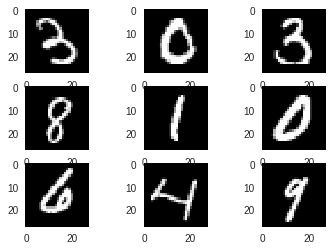

In [0]:
montage(trainimages[0:9])

Compute mean of images in each digit class

In [0]:
trainmeans = torch.zeros((10,28,28))
for i in range(10):
    indices = (trainlabels == i).nonzero()[:,0]
    images = trainimages[indices]
    trainmeans[i] = torch.mean(images.float(), dim=0)

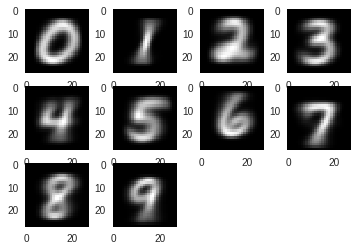

In [0]:
montage([trainmeans[i] for i in range(10)])

Compute distribution over digit classes in training set

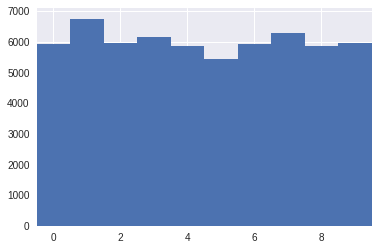

In [0]:
plt.hist(trainlabels.numpy(), bins=[-0.5 + i for i in range(11)])
plt.xlim([-0.5, 9.5])
plt.show()

**Explanation:**

The outer black is because the value in this area of all sample images are nearly all identical: zero.  
The gray and white in the middle is the variance of the handwritten among different people.

The inner black is because this area is filled in all samples (all 10 digits). Therefore the standard deviation becomes small.